In [2]:
import os
import sys
sys.path.append("/home/nakamura/network_dissection/NetDissect/src/")
import dream

import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn
import gd_parameters as gd

from gd_features import Features
from gd_cnn import CnnModel

% matplotlib inline

In [3]:
plt.style.use("seaborn-white")

In [4]:
image_dir = "/home/nakamura/network_dissection/NetDissect/dissection/alexnet_imagenet_full_conv_384/html/image/"

In [5]:
data_dir = gd.data_dir
subject_list = gd.subject_list
roi_list = gd.roi_list
feature_file = gd.feature_file
feature_type = gd.feature_type
result_dir = gd.result_dir
feature_file = gd.feature_file
feature_type = gd.feature_type
result_dir = gd.result_dir
features = Features(os.path.join(data_dir, feature_file), feature_type)

In [6]:
# Feture selection settings
num_features = 1000

# CNN model settings
model_def = './data/cnn/caffe_reference_imagenet/caffe_reference_imagenet.prototxt'
model_param = './data/cnn/caffe_reference_imagenet/caffe_reference_imagenet.caffemodel'
cnn_layers = ('conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8')

mean_image_file = './data/images/ilsvrc_2012_mean.npy'  # ImageNet Large Scale Visual Recognition Challenge 2012

# Misc settings
rand_seed = 2501

model = CnnModel(model_def, model_param, mean_image_file, batch_size=128, rand_seed=rand_seed)
net = model.net
feat_ind = model.feat_index

In [8]:
with open(os.path.join(result_dir, "UnitAccuracyMean.pkl"), "rb") as f:
    acc_unit = pickle.load(f)

In [9]:
def get_channel(blob, n):
    """
    return index of channel wehere unit n in blob belongs to
    chanenl index starts from zero
    """
    if blob in ("conv1", "conv2", "conv3", "conv4", "conv5"):
        ind = feat_ind[blob][n - 1]
        blob_shape = net.blobs[blob].data[0].shape
        resolution = blob_shape[1] * blob_shape[2]
        channel = ind // resolution
        return blob, channel
    else:
        return blob, feat_ind[blob][n-1]    

In [10]:
def get_ordered_iou(blob,channel, n=10):
    """return ordered_iou averaged in a layer as pandas.Series
    use ration of channels exceeding threshold
    """
    if blob in ("conv1", "conv2", "conv3", "conv4", "conv5"):
        path= os.path.join("/home/nakamura/network_dissection/NetDissect/dissection/alexnet_imagenet_full_conv_384",
                       blob + "-iou.csv")
    else:
        path= os.path.join("/home/nakamura/network_dissection/NetDissect/dissection/alexnet_imagenet_full_conv_384",
                       blob + "-conv-iou.csv") 
    iou = pd.read_csv(path, index_col=0)
    channel_iou = iou.iloc[channel]
    sorted_iou = channel_iou.sort_values(ascending=False)
    sorted_label = sorted_iou.index.tolist()[:n]
    label = ",".join(sorted_label)

    return label

In [11]:
def top_decodable(selection, n=10, worst=False):
    if selection in roi_list:
        acc_unit_temp = acc_unit.loc[roi]
    elif selection in features.layers:
        acc_unit_temp = acc_unit.loc[("VC", selection)]
        
    if worst:
        acc_sorted = acc_unit_temp.sort_values("accuracy", ascending=True)
        top_decodable = acc_sorted.index.values[:n]       
    else:
        acc_sorted = acc_unit_temp.sort_values("accuracy", ascending=False)
        top_decodable = acc_sorted.index.values[:n]
    
    return top_decodable

In [12]:
def top_decodable_channel(selection, n=10, worst=False):
    if selection in roi_list:
        top = top_decodable(selection, n, worst)
        top_channel = []
        for i in range(len(top)):
            top_channel.append(get_channel(top[i][0], top[i][1]))
            
    elif selection in features.layers:
        top = top_decodable(selection, n, worst)
        top_channel = []
        for i in range(len(top)):
            top_channel.append(get_channel(selection, top[i]))
            
    return top_channel

In [13]:
def make_pf_image(blob, channel):
    pf = dream.PreferedImage(height=384, width=384)
    return pf.get_pf_image(blob, channel)

In [19]:
def get_channel_image(blob, channel):
    if blob in ("conv1", "conv2", "conv3", "conv4", "conv5"):
        file_name = "{}-{:04d}.jpg".format(blob, channel)
        path_to_image = os.path.join(image_dir, file_name)
        return path_to_image
    else:
        file_name = "{}-conv-{:04d}.jpg".format(blob, channel)
        path_to_image = os.path.join(image_dir, file_name)
        return path_to_image

# make image table for top decodable concepts

In [ ]:
for roi in roi_list:
    top_channel = top_decodable_channel(roi)
    fig, axes = plt.subplots(10, 1, figsize=(20, 12))
    for ch, ax in zip(top_channel, axes):
        img = mpimg.imread(get_channel_image(*ch))
        ax.imshow(img)
        ax.set_axis_off()
    fig.savefig(os.path.join(result_dir,"figures/", "top_decodable_images_{}.pdf".format(roi)), bbox_inches="tight")

In [ ]:
# for best channels
for feat in features.layers[:7]:
    top_channel = top_decodable_channel(feat, n=5)
    fig, axes = plt.subplots(5, 1, figsize=(20, 6))
    for ch, ax in zip(top_channel, axes):
        img = mpimg.imread(get_channel_image(*ch))
        ax.imshow(img)
        ax.set_axis_off()
    fig.savefig(os.path.join(result_dir,"figures/", "top_decodable_images_{}.pdf".format(feat)), bbox_inches="tight")
    fig.savefig(os.path.join(result_dir,"figures/png", "top_decodable_images_{}.png".format(feat)), bbox_inches="tight", dpi=300)

In [ ]:
# for worst channels
for feat in features.layers[:7]:
    top_channel = top_decodable_channel(feat, n=5, worst=True)
    fig, axes = plt.subplots(5, 1, figsize=(20, 6))
    for ch, ax in zip(top_channel, axes):
        img = mpimg.imread(get_channel_image(*ch))
        ax.imshow(img)
        ax.set_axis_off()
    fig.savefig(os.path.join(result_dir, "figures/", "top_decodable_images_{}_worst.pdf".format(feat)), bbox_inches="tight")
    fig.savefig(os.path.join(result_dir, "figures/png", "top_decodable_images_{}_worst.png".format(feat)), bbox_inches="tight",dpi=300)

# make table for top decodable concepts

In [ ]:
# make tab separated table
# top decodable concepts for each roi
n = 10
df = pd.DataFrame(index=np.arange(1,n + 1),columns=roi_list)

for roi in roi_list:
    top_channel = top_decodable_channel(roi, n)
    for i in range(n):
        # get ordered iou of top nth best decodable
        concepts = get_ordered_iou(*top_channel[i], n=n)
        df[roi].iloc[i]= concepts 

df.to_csv(os.path.join(result_dir, "figures/" ,"decodable_concept_sbj_mean.csv"), sep="\t")

In [ ]:
# make tab separated table
# top decodable concepts for each layer
n = 10
df = pd.DataFrame(index=np.arange(1,n + 1),columns=features.layers[:7])

for feat in features.layers[:7]:
    top_channel = top_decodable_channel(feat, n)
    for i in range(n):
        # get ordered iou of top nth best decodable
        concepts = get_ordered_iou(*top_channel[i], n=n)
        df[feat].iloc[i]= concepts 

df.to_csv(os.path.join(result_dir, "figures/" ,"decodable_concept_layers_sbj_mean.csv"), sep="\t")

In [ ]:
# for worst decodable channels
# make tab separated table
# top decodable concepts for each layer
n = 10
df = pd.DataFrame(index=np.arange(1,n + 1),columns=features.layers[:7])

for feat in features.layers[:7]:
    top_channel = top_decodable_channel(feat, n, worst=True)
    for i in range(n):
        # get ordered iou of top nth best decodable
        concepts = get_ordered_iou(*top_channel[i], n=n)
        df[feat].iloc[i]= concepts 

df.to_csv(os.path.join(result_dir, "figures/" ,"decodable_concept_layers_sbj_mean_worst.csv"), sep="\t")

# make prefered_image

creating prefered image for conv3 channel 0346
iter_000
iter_001
iter_002
iter_003
iter_004
iter_005
iter_006
iter_007
iter_008
iter_009
iter_010
iter_011
iter_012
iter_013
iter_014
iter_015
iter_016
iter_017
iter_018
iter_019
iter_020
iter_021
iter_022
iter_023
iter_024
iter_025
iter_026
iter_027
iter_028
iter_029
creating prefered image for conv3 channel 0132
iter_000
iter_001
iter_002
iter_003
iter_004
iter_005
iter_006
iter_007
iter_008
iter_009
iter_010
iter_011
iter_012
iter_013
iter_014
iter_015
iter_016
iter_017
iter_018
iter_019
iter_020
iter_021
iter_022
iter_023
iter_024
iter_025
iter_026
iter_027
iter_028
iter_029
creating prefered image for conv4 channel 0069
iter_000
iter_001
iter_002
iter_003
iter_004
iter_005
iter_006
iter_007
iter_008
iter_009
iter_010
iter_011
iter_012
iter_013
iter_014
iter_015
iter_016
iter_017
iter_018
iter_019
iter_020
iter_021
iter_022
iter_023
iter_024
iter_025
iter_026
iter_027
iter_028
iter_029
creating prefered image for conv2 channel 0012
it

KeyError: 'fc8'

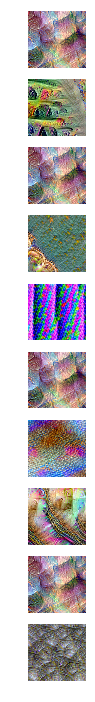

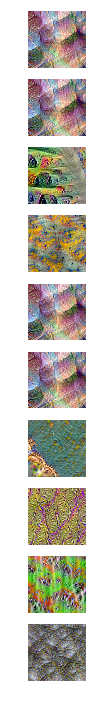

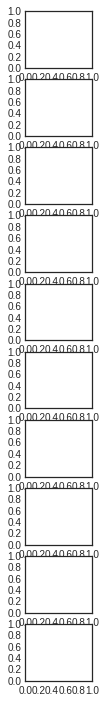

In [21]:
for roi in roi_list:
    top_channel = top_decodable_channel(roi)
    fig, axes = plt.subplots(10, 1, figsize=(1.2, 12))
    for ch, ax in zip(top_channel, axes):
        img = make_pf_image(*ch)
        ax.imshow(img)
        ax.set_axis_off()
    fig.savefig(os.path.join(result_dir,"figures/", "top_prefered_image_{}.pdf".format(roi)), bbox_inches="tight")

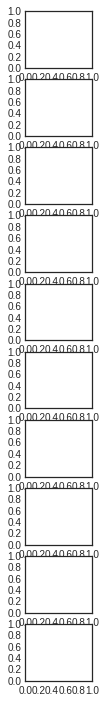

In [26]:
% matplotlib inline
fig
